# Semantic Deduplication on Text

GPU accelerated implementation of [SemDeDup: Data-efficient learning at web-scale through semantic deduplication](https://arxiv.org/abs/2303.09540)  

In [ ]:
import os

os.environ["LOGURU_LEVEL"] = "ERROR"

import pandas as pd

input_path_to_data = "/path/to/data"
semantic_out_dir = os.path.abspath("./output/step_by_step")
output_path = os.path.join(semantic_out_dir, "output")
cache_path = os.path.join(semantic_out_dir, "cache")
input_filetype = "parquet"  # this can be either of jsonl or parquet
output_filetype = "parquet"  # this can be either of jsonl or parquet

# Running SemDedup workflow by workflow

Here we intentionally break it down into executing three workflows. 

We also use id generator to show it works when running it separately.

1. Create id generator.
2. Running embedding generation
3. Running kmeans + pairwise (without duplicate identification)
4. Run duplicate identification
5. Run removal

Both steps 2 and 5 require the use of id generator created in step 1. 

In [ ]:
from nemo_curator.core.client import RayClient

client = RayClient(num_cpus=64, num_gpus=4)
client.start()

2025-09-16 12:09:02,134	INFO usage_lib.py:447 -- Usage stats collection is disabled.
2025-09-16 12:09:02,134	INFO scripts.py:913 -- Local node IP: 127.0.1.1


## Create Id Generator

1. This just creates a Ray Actor in the background.
2. When we read our dataset now, this actor in the background is used to assign monotonically increasing int ids to each row. 

In [3]:
from nemo_curator.stages.deduplication.id_generator import create_id_generator_actor

create_id_generator_actor()

2025-09-16 12:09:02,673	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:09:02,677	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:09:05,149	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


2025-09-16 12:09:05,014	SUCC scripts.py:949 -- --------------------
2025-09-16 12:09:05,014	SUCC scripts.py:950 -- Ray runtime started.
2025-09-16 12:09:05,014	SUCC scripts.py:951 -- --------------------
2025-09-16 12:09:05,014	INFO scripts.py:953 -- Next steps
2025-09-16 12:09:05,014	INFO scripts.py:956 -- To add another node to this Ray cluster, run
2025-09-16 12:09:05,015	INFO scripts.py:959 --   ray start --address='127.0.1.1:6379'
2025-09-16 12:09:05,015	INFO scripts.py:968 -- To connect to this Ray cluster:
2025-09-16 12:09:05,015	INFO scripts.py:970 -- import ray
2025-09-16 12:09:05,015	INFO scripts.py:971 -- ray.init(_node_ip_address='127.0.1.1')
2025-09-16 12:09:05,015	INFO scripts.py:983 -- To submit a Ray job using the Ray Jobs CLI:
2025-09-16 12:09:05,015	INFO scripts.py:984 --   RAY_API_SERVER_ADDRESS='http://127.0.0.1:8265' ray job submit --working-dir . -- python my_script.py
2025-09-16 12:09:05,015	INFO scripts.py:993 -- See https://docs.ray.io/en/latest/cluster/running

## Run Embedding Generation

1. We output as parquet because that way we can read more smartly during our KMeans step. This is the recommended file format before you run KMeans.


In [4]:
from nemo_curator.pipeline import Pipeline
from nemo_curator.stages.text.embedders import EmbeddingCreatorStage
from nemo_curator.stages.text.io.reader import ParquetReader
from nemo_curator.stages.text.io.writer import ParquetWriter

embedding_output_path = os.path.join(cache_path, "embeddings")

embedding_pipeline = Pipeline(
    name="embedding_pipeline",
    stages=[
        # We specify _generate_ids=True to use the id generator we created in step 1.
        ParquetReader(file_paths=input_path_to_data, files_per_partition=1, fields=["text"], _generate_ids=True),
        EmbeddingCreatorStage(
            model_identifier="sentence-transformers/all-MiniLM-L6-v2",
            text_field="text",
            max_seq_length=None,
            max_chars=None,
            embedding_pooling="mean_pooling",
            model_inference_batch_size=256,
        ),
        # We specify the fields out so that we also don't end up writing the `text` field, which is no longer needed.
        ParquetWriter(
            path=embedding_output_path, fields=["_curator_dedup_id", "input_ids", "attention_mask", "embeddings"]
        ),
    ],
)

embedding_out = embedding_pipeline.run()

2025-09-16 12:09:16,142	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:09:16,144	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:09:16,151	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 12:09:16,166	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:09:16,168	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:09:16,168	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 11292.21it/s]


### Save Id Generator to disk and kill the actor

In [ ]:
from nemo_curator.stages.deduplication.id_generator import kill_id_generator_actor, write_id_generator_to_disk

id_generator_actor_path = os.path.join(output_path, "semantic_id_generator.json")
write_id_generator_to_disk(id_generator_actor_path)
kill_id_generator_actor()

2025-09-16 12:14:33,178	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:14:33,182	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:14:33,191	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


(KMeansReadFitWriteStage pid=1900678) 203520000
(KMeansReadFitWriteStage pid=1900684) 203520000
(KMeansReadFitWriteStage pid=1900677) 203520000
(KMeansReadFitWriteStage pid=1900681) 203323776


#### Embeddings

1. `id` : The id field from our original dataset. 
    - For all subsequent steps this is assumed to be the  `id_field`
    - If you had set `use_id_generator` to `True` then instead of this you would see the `_curator_dedup_id` spcified. The id in that field is generated using our IdGenerator which assigns integer ids to each row in input data that later is used in removal. 
2. `embeddings` : The embedding generated by the model we used above.

In [6]:
embeddings_path = os.path.join(cache_path, "embeddings")

pd.read_parquet(os.path.join(embeddings_path, os.listdir(embeddings_path)[0])).head()

,_curator_dedup_id,input_ids,attention_mask,embeddings
0,50000,"[101, 2320, 2045, 2001, 1037, 4206, 3203, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.03838138282299042, 0.047589678317308426, 0..."
1,50001,"[101, 2320, 2588, 1037, 2051, 2045, 2001, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.012109456583857536, 0.05599193274974823, 0...."
2,50002,"[101, 2320, 2588, 1037, 2051, 2045, 2001, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.021665604785084724, 0.06978840380907059, 0..."
3,50003,"[101, 2320, 2045, 2001, 1037, 2210, 2611, 2315...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.07565540075302124, -0.032156478613615036, ..."
4,50004,"[101, 8410, 1996, 7481, 4845, 3866, 2000, 8145...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.016478808596730232, 0.07793284207582474, 0..."


## Run Semantic Dedup workflow (w/o specifying `eps`)

1. We intentionally don't specify `eps` so that we can show how to run `IdentifyDuplicates` as a separate stage.

In [7]:
from nemo_curator.stages.deduplication.semantic import RankingStrategy, SemanticDeduplicationWorkflow

semantic_workflow_path = os.path.join(cache_path, "semantic_dedup")

workflow = SemanticDeduplicationWorkflow(
    input_path=embedding_output_path,
    output_path=semantic_workflow_path,
    n_clusters=100,
    # Since we use Id Generator in the embedding generation step, we need to specify the id field as `_curator_dedup_id`
    id_field="_curator_dedup_id",
    embedding_field="embeddings",
    ranking_strategy=RankingStrategy(metadata_cols=["cosine_dist_to_cent"], ascending=True),
    # if eps is specified then it'll also run IdentifyDuplicates stage
    eps=None,
)
semantic_out = workflow.run()

2025-09-16 12:14:38,372	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:14:38,374	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:14:38,375	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
2025-09-16 12:15:04,622	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:15:04,624	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:15:04,632	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 12:15:04,647	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:15:04,649	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:15:04,649	INFO worker.py:1789 -- Calling ray.init() again after it

#### KMeans Results

1. `_curator_dedup_id` : The ids of the rows that belong to the cluster.
2. `embeddings` : These are later used for pairwise similarity
3. `l2_dist_to_cent` / `cosine_dist_to_cent` : This represents how far (l2 distance or cosine distance) is from our clusters centroid.
    - These fields help us define how we want to prioritize ranking within our cluster. See `RankingStratergy`
    - If we had other `metadata_fields` provided they would be used here instead.


In [8]:
kmeans_path_first_centroid = os.path.join(semantic_workflow_path, "kmeans_results", "centroid=0")

pd.read_parquet(os.path.join(kmeans_path_first_centroid, os.listdir(kmeans_path_first_centroid)[0])).head()

,_curator_dedup_id,embeddings,l2_dist_to_cent,cosine_dist_to_cent
0,1559534,"[-0.11826241, 0.08439316, 0.0113494955, -0.025...",0.592360,0.194041
1,1559710,"[-0.052437697, 0.04991796, -0.03742547, 0.0304...",0.687144,0.271335
2,1559720,"[-0.07459514, 0.031523816, 0.049211908, -0.003...",0.558832,0.169442
3,1559748,"[-0.09493365, 0.09627606, -0.006429509, 0.0233...",0.633781,0.226411
4,1560061,"[-0.08274115, 0.1369494, 0.007629799, -0.01132...",0.572499,0.179296


#### Pairwise Similarity Result

1. `id` : The identifier for the duplicate row.
2. `max_id` : The closest pair for the duplicate row.
3. `cosine_sim_score` : The cosine similarity between the two points


In [9]:
pairwise_path = os.path.join(cache_path, "semantic_dedup", "pairwise_results")

pd.read_parquet(os.path.join(pairwise_path, "cluster_0.parquet")).head()

,id,max_id,cosine_sim_score
0,1176969,1176969,0.000000
1,1657631,1176969,0.832831
2,1258502,1657631,1.000000
3,2009161,1176969,0.863873
4,1739290,2009161,1.000000


#### Investigate results of Semantic Workflow

Depending on our dataset size we can read through all of the files and plot how much data is similar to one another.
Here we show how to read file by file and then perform a reduce. 

Based on the analysis here we can decide what our `eps`, and proceed to identify the duplicates and then perform removal.

**NOTE : If you run with `use_id_generator=False` (which affects removal performance at large scale) you will see the actual ids of instead of the int ids. You can then also inspect the original dataset for those ids, and that can also help your decision for `eps`**

In [10]:
from collections import Counter
from functools import reduce

import numpy as np

pairwise_path = os.path.join(semantic_workflow_path, "pairwise_results")


def get_bins(df: pd.DataFrame, num_bins: int = 1_000) -> dict[float, int]:
    bins = np.linspace(0, 1.01, num_bins)

    return Counter(
        pd.cut(df["cosine_sim_score"], bins=bins, labels=bins[1:], retbins=False, include_lowest=True, right=True)
        .value_counts()
        .to_dict()
    )


similarity_across_dataset = reduce(
    lambda x, y: x + y,
    [
        get_bins(pd.read_parquet(os.path.join(pairwise_path, f), columns=["cosine_sim_score"]), num_bins=1000)
        for f in os.listdir(pairwise_path)
    ],
)

Looking at the graph below we see 20% of our dataset is above 0.9 cosine similarity. So for the purpose of this tutorial we can use 0.1 (1 - 0.9) as our `eps` parameter.

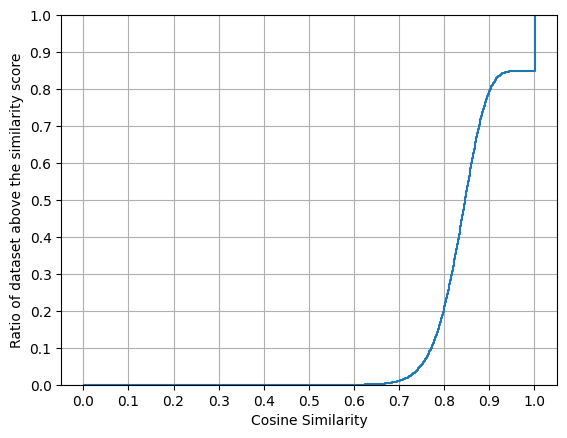

In [11]:
import matplotlib.pyplot as plt

plt.ecdf(x=similarity_across_dataset.keys(), weights=similarity_across_dataset.values())
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("Cosine Similarity")
plt.ylabel("Ratio of dataset above the similarity score")
plt.grid()
plt.show()

## Identify Duplicates

We will create a simple pipeline that now identifies duplicates and writes them out.

In [12]:
from nemo_curator.pipeline import Pipeline
from nemo_curator.stages.deduplication.semantic import IdentifyDuplicatesStage
from nemo_curator.stages.file_partitioning import FilePartitioningStage
from nemo_curator.utils.file_utils import create_or_overwrite_dir

duplicates_output_path = os.path.join(output_path, "duplicates")
create_or_overwrite_dir(duplicates_output_path)

identify_duplicates_pipeline = Pipeline(
    name="identify_duplicates_pipeline",
    stages=[
        FilePartitioningStage(
            file_paths=pairwise_path,
            # we select files per partition to be 1, because IdentifyDuplicates has default batch_size of 10
            # this means it'll process 10 files at a time
            files_per_partition=1,
        ),
        IdentifyDuplicatesStage(
            output_path=duplicates_output_path,
            eps=0.1,
        ),
    ],
)

identify_duplicates_out = identify_duplicates_pipeline.run()

2025-09-16 12:17:17,367	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:17:17,370	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:17:17,379	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 12:17:17,395	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:17:17,397	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:17:17,397	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
(pid=1955162) [2025-09-16 12:17:20,462 E 1955162 1959591] core_worker.cc:4075: Mismatched ActorID: ignoring KillActor for previous actor 4c7bc8a18801268188a389b305000000, current actor ID: NIL_ID
(pid=1955126) [2025-09-16 12:17:20,462 E 1955126 1959516] core_worker.cc:4075: Mismatched ActorID: ignoring KillActo

#### Looking at duplicates

- `id` : This is a list of all ids that are above our similarity threshold `eps`.

In [13]:
pd.read_parquet(os.path.join(duplicates_output_path, os.listdir(duplicates_output_path)[0])).head()

,id
0,656
1,711
2,807
3,842
4,868


## Removing Duplicates

1. We load the persisted id generator
2. Run the removal workflow
3. Kill the id generator

### Notes
1. When running removal workflow, we must specify the same input configuration as we did when we "generated ids".
2. In this tutorial that happened at the embedding generation step.
3. Therefore its required that we match the saame arguments of filepath, filetype and files_per_partition / blocksize.
4. This is required because ids are generated based on hash(filenames) in each task. If the same hash is not found in the id generator it'll error out.

### Performance
1. If you notice OOMs during this stage you can try using RayDataActor


### How TextDuplicatesRemovalWorkflow works
1. It starts the id generator using `create_id_generator(filepath=???)`
1. It runs a pipeline that does [ParquetReader, TextDuplicatesRemovalStage, ParquetWriter] (assuming input/output filetypes are parquet)
1. Kills the id generator using `kill_id_generator_actor`


In [14]:
from nemo_curator.stages.text.deduplication.removal_workflow import TextDuplicatesRemovalWorkflow

duplicates_output_path = os.path.join(output_path, "duplicates")

# The workflow starts from a new IdGenerator from the persisted id generator
# This helps it assign the same ids back to the same file
# It is important the we read again the same dataset using the same file path and files_per_partition / blocksize arguments
id_generator_path = os.path.join(output_path, "semantic_id_generator.json")

removal_workflow = TextDuplicatesRemovalWorkflow(
    input_path=input_path_to_data,
    ids_to_remove_path=duplicates_output_path,
    output_path=os.path.join(output_path, "deduplicated"),
    # input args
    input_filetype=input_filetype,
    input_fields=["text"],
    input_files_per_partition=1,
    # output args
    output_filetype=output_filetype,
    output_fields=["text", "_curator_dedup_id"],
    # id args
    ids_to_remove_duplicate_id_field="id",  # this is the field that contains the ids of the duplicates
    id_generator_path=id_generator_path,
)

removal_out = removal_workflow.run()

2025-09-16 12:18:13,253	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:18:13,255	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:18:13,263	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 12:18:13,570	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:18:13,572	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:18:13,579	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 12:18:13,595	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 12:18:13,597	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 12:18:13,598	INFO worker.py:1789 -- Calling ray.init() ag

### Looking at deduplicated dataset

In [15]:
deduplicated_path = os.path.join(output_path, "deduplicated")

pd.read_parquet(os.path.join(deduplicated_path, os.listdir(deduplicated_path)[0])).head()

,text,_curator_dedup_id
0,Once upon a time there was a frog. He lived i...,80000
1,Once there was a tired mule. He was tired fro...,80001
2,"Once upon a time, there was a big family. Eve...",80002
3,"One day, a young girl was singing in the park...",80003
4,"One day, Timmy was excited to learn something...",80004


## Printing statistics of the dataset

In [16]:
number_of_input_rows = sum(task._stage_perf[1].num_items_processed for task in removal_out)
number_of_output_rows = sum([task._stage_perf[2].num_items_processed for task in removal_out])
number_of_removed_rows = sum([task._metadata.get("num_removed") for task in removal_out])

print(f"Number of input rows\t: {number_of_input_rows:,}")
print(f"Number of output rows\t: {number_of_output_rows:,}")
print(f"Number of removed rows\t: {number_of_removed_rows:,}")
print(f"Ratio of removed rows\t: {(number_of_removed_rows * 100 / number_of_input_rows):.2f}%")

Number of input rows	: 2,119,489
Number of output rows	: 1,682,787
Number of removed rows	: 436,702
Ratio of removed rows	: 20.60%


## Stop the cluster

In [ ]:
client.stop()

: 